In [63]:
import tensorflow as tf 

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import model_from_json, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, ZeroPadding2D, AveragePooling2D
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, Input, Lambda, BatchNormalization, add
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.regularizers import l2

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import pickle
import os, sys

In [2]:
# Creates image data generators for training
train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    'data/train_gen',
    target_size=(64, 64),
    batch_size=32,
    color_mode="rgb",
    class_mode='sparse')

validation_generator = test_datagen.flow_from_directory(
    'data/validation_gen',
    target_size=(64, 64),
    batch_size=32,
    color_mode="rgb",
    class_mode='sparse')

# shows how many images we have in each set
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

Found 28459 images belonging to 4 classes.
Found 7108 images belonging to 4 classes.


In [113]:
# test generator
test_generator = test_datagen.flow_from_directory(
    directory="data/test/",
    target_size=(64, 64),
    batch_size=1
)

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 12 images belonging to 1 classes.


In [ ]:
# we have 12 test images just to visualize our predictions
test_images = ["data/test/test_images/jh_31.jpg",
               "data/test/test_images/jh_32.jpg",
               "data/test/test_images/jh_33.jpg",
               "data/test/test_images/mh_31.jpg",
               "data/test/test_images/mh_32.jpg",
               "data/test/test_images/mh_33.jpg",
               "data/test/test_images/sc_31.jpg",
               "data/test/test_images/sc_32.jpg",
               "data/test/test_images/sc_33.jpg",
               "data/test/test_images/wl_31.jpg",
               "data/test/test_images/wl_32.jpg",
               "data/test/test_images/wl_33.jpg"] 

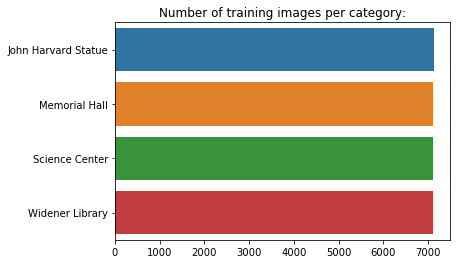

In [3]:
import seaborn as sns
train_data_dir = "data/train_gen"
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
good_labels = {"wl" : "Widener Library", "sc" : "Science Center", "mh" : "Memorial Hall", "jh" : "John Harvard Statue"}

class_names = sorted(os.listdir('data/train_gen'))
img_per_class = []

for name in class_names:
    folder = 'data/train_gen' + '/' + name
    img_per_class.append(len(os.listdir(folder)))

classes = [good_labels['jh'], good_labels['mh'], good_labels['sc'], good_labels['wl']]
sns.barplot(y=classes, x=img_per_class).set_title("Number of training images per category:")
plt.show()

In [193]:
# Plots history of trained model

total_classes = 4
baseline = 1/total_classes

# plots history of the model
def plot_history(history, name):
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    for i, metric in enumerate(['loss', 'accuracy']):
        ax[i].plot(history.history[metric], label='train', c='b')
        ax[i].plot(history.history[f'val_{metric}'], label='val', c='r')
        if metric == 'accuracy': ax[i].axhline(baseline, c='g', ls='--', label='Baseline accuracy')
        ax[i].set_xlabel('epoch')
        ax[i].set_ylabel(metric)
    plt.suptitle(f'{name} Performance', y=1.05)
    plt.legend()
    plt.tight_layout()

# visualizes prediction of the model
def test_model(model):
    for path in test_images:
        im = Image.open(path)
        im_f = im.resize((64,64))
        image = img_to_array(im_f)
        image = np.expand_dims(image, axis=0)
        p = np.argmax(model.predict(image), axis = 1)
        plt.imshow(im_f)
        plt.title("Predicted by model: " + good_labels[labels[p[0]]])
        plt.show()

In [202]:
# We start with a basic neural network

basic_nn = Sequential()
basic_nn.add(Flatten())  
basic_nn.add(Dense(64, activation='relu'))
basic_nn.add(Dense(total_classes, activation='sigmoid'))
basic_nn.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [203]:
history1 = basic_nn.fit(
        train_generator,
        steps_per_epoch= STEP_SIZE_TRAIN,
        epochs=20,
        validation_data=validation_generator,
        validation_steps= STEP_SIZE_VALID)

  ...
    to  
  ['...']
Train for 889 steps, validate for 222 steps
Epoch 1/20
889/889 [==============================] - 31s 35ms/step - loss: 5.1209 - accuracy: 0.2505 - val_loss: 5.1372 - val_accuracy: 0.2486
Epoch 2/20
889/889 [==============================] - 25s 28ms/step - loss: 5.1246 - accuracy: 0.2503 - val_loss: 5.1372 - val_accuracy: 0.2486
Epoch 3/20
889/889 [==============================] - 26s 29ms/step - loss: 5.1207 - accuracy: 0.2505 - val_loss: 5.1372 - val_accuracy: 0.2486
Epoch 4/20
889/889 [==============================] - 26s 29ms/step - loss: 5.1229 - accuracy: 0.2504 - val_loss: 5.1372 - val_accuracy: 0.2486
Epoch 5/20
889/889 [==============================] - 28s 32ms/step - loss: 5.1201 - accuracy: 0.2505 - val_loss: 5.1372 - val_accuracy: 0.2486
Epoch 6/20
889/889 [==============================] - 30s 34ms/step - loss: 5.1246 - accuracy: 0.2503 - val_loss: 5.1372 - val_accuracy: 0.2486
Epoch 7/20
889/889 [==============================] - 32s 36ms/step

In [205]:
basic_nn.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         multiple                  0         
_________________________________________________________________
dense_22 (Dense)             multiple                  786496    
_________________________________________________________________
dense_23 (Dense)             multiple                  260       
Total params: 786,756
Trainable params: 786,756
Non-trainable params: 0
_________________________________________________________________


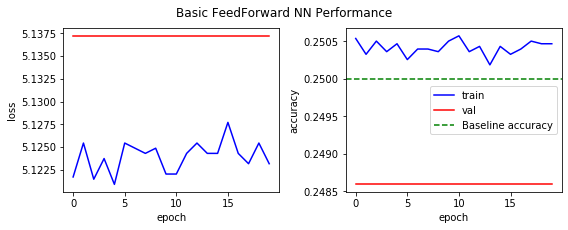

In [206]:
plot_history(history1, 'Basic FeedForward NN')

In [207]:
# we try our luck with a CNN

cnn1 = Sequential()

cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(64, activation='relu'))
cnn1.add(Dense(total_classes, activation='softmax'))

cnn1.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [208]:
history2 = cnn1.fit(
        train_generator,
        steps_per_epoch= STEP_SIZE_TRAIN,
        epochs=20,
        validation_data=validation_generator,
        validation_steps= STEP_SIZE_VALID)

  ...
    to  
  ['...']
Train for 889 steps, validate for 222 steps
Epoch 1/20
889/889 [==============================] - 79s 89ms/step - loss: 9.5863 - accuracy: 0.8397 - val_loss: 1.2428 - val_accuracy: 0.7597
Epoch 2/20
889/889 [==============================] - 79s 89ms/step - loss: 0.3114 - accuracy: 0.9441 - val_loss: 1.5683 - val_accuracy: 0.7965
Epoch 3/20
889/889 [==============================] - 79s 89ms/step - loss: 0.1923 - accuracy: 0.9719 - val_loss: 13.7775 - val_accuracy: 0.7356
Epoch 4/20
889/889 [==============================] - 79s 89ms/step - loss: 0.2056 - accuracy: 0.9786 - val_loss: 4.6727 - val_accuracy: 0.7718
Epoch 5/20
889/889 [==============================] - 80s 90ms/step - loss: 0.1410 - accuracy: 0.9849 - val_loss: 4.0649 - val_accuracy: 0.8214
Epoch 6/20
889/889 [==============================] - 79s 89ms/step - loss: 0.1295 - accuracy: 0.9876 - val_loss: 5.2447 - val_accuracy: 0.8240 - loss: 0.1303 
Epoch 7/20
889/889 [==============================

In [20]:
cnn1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            multiple                  896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
flatten_4 (Flatten)          multiple                  0         
_________________________________________________________________
dense_8 (Dense)              multiple                  1968192   
_________________________________________________________________
dense_9 (Dense)              multiple                  260       
Total params: 1,969,348
Trainable params: 1,969,348
Non-trainable params: 0
____________________________________________

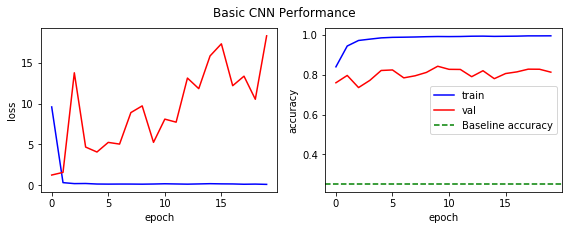

In [209]:
plot_history(history2, 'Basic CNN')

In [115]:
cnn2 = Sequential()
cnn2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = (64,64,3)))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D((2, 2)))
cnn2.add(Dropout(0.2))

cnn2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Dropout(0.4))

cnn2.add(Flatten())
cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dropout(0.3))
cnn2.add(Dense(total_classes, activation='softmax'))

cnn2.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
history3 = cnn2.fit(
        train_generator,
        steps_per_epoch= STEP_SIZE_TRAIN,
        epochs=10,
        validation_data=validation_generator,
        validation_steps= STEP_SIZE_VALID)

  ...
    to  
  ['...']
Train for 889 steps, validate for 222 steps
Epoch 1/10
889/889 [==============================] - 233s 263ms/step - loss: 0.3524 - accuracy: 0.9218 - val_loss: 3.4907 - val_accuracy: 0.6879
Epoch 2/10
889/889 [==============================] - 240s 270ms/step - loss: 0.1131 - accuracy: 0.9761 - val_loss: 2.5378 - val_accuracy: 0.8005
Epoch 3/10
889/889 [==============================] - 241s 271ms/step - loss: 0.0681 - accuracy: 0.9861 - val_loss: 7.7287 - val_accuracy: 0.6819
Epoch 4/10
889/889 [==============================] - 233s 262ms/step - loss: 0.0625 - accuracy: 0.9886 - val_loss: 3.7077 - val_accuracy: 0.8477
Epoch 5/10
889/889 [==============================] - 244s 275ms/step - loss: 0.0600 - accuracy: 0.9894 - val_loss: 5.3967 - val_accuracy: 0.8167
Epoch 6/10
889/889 [==============================] - 236s 266ms/step - loss: 0.0417 - accuracy: 0.9928 - val_loss: 4.3567 - val_accuracy: 0.8212
Epoch 7/10
889/889 [==============================] - 2

In [122]:
cnn2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 64)      

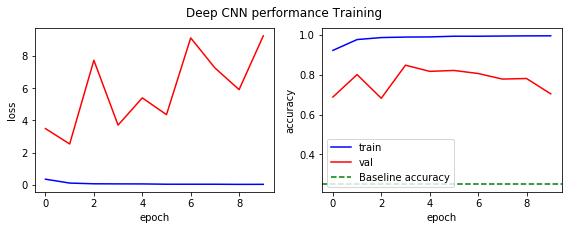

In [168]:
plot_history(history3, 'Deep CNN')

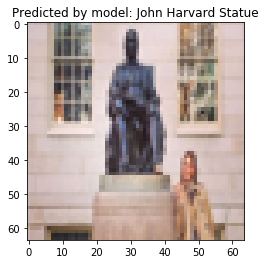

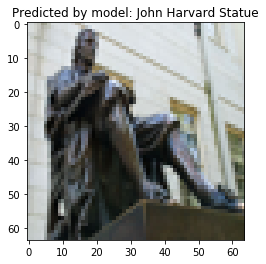

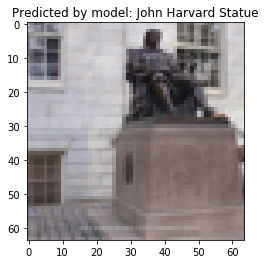

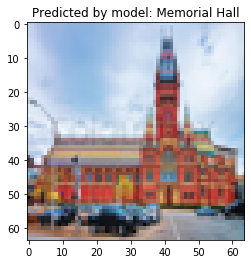

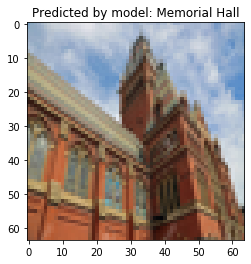

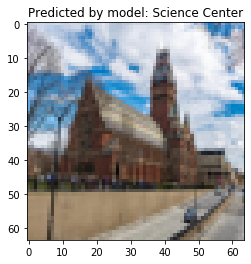

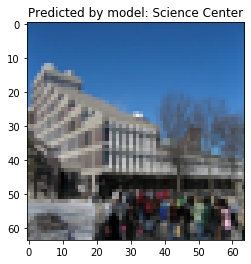

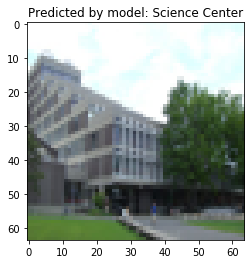

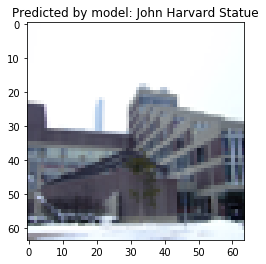

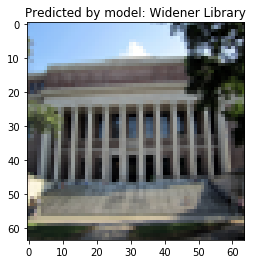

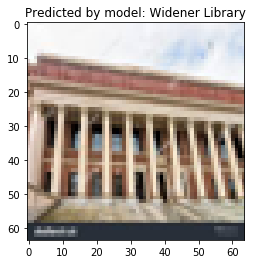

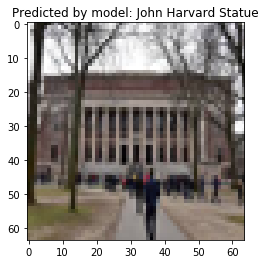

In [117]:
test_model(cnn2)

In [89]:
basic_nn.save_weights("basic_nn.h5")
cnn1.save_weights("cnn1.h5")
cnn2.save_weights("cnn2.h5")
print("Saved weights")

Saved weights


In [116]:
basic_nn.load_weights("basic_nn.h5")
cnn1.load_weights("cnn1.h5")
cnn2.load_weights("cnn2.h5")
print("Loaded weights")

Loaded weights


In [7]:
# It seems our models have reached its peak performance
# Let's try some transfer learning: 
# https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import layers, models, Model, optimizers

In [16]:
# we use a pre-trained deep learning model (VGG16) as the basis for our image classifier model,
# and then retrain the model on our own data, i.e. transfer learning

vgg_base = vgg16.VGG16(weights='imagenet', include_top=False, pooling='max', input_shape = (64,64, 3))
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [17]:
# I personally don't think data is complex enough
# So let's just keep the last 3 layers of the base vgg trainable
# which includes one convolutional layer with parameters

for layer in vgg_base.layers[:-3]:
    layer.trainable = False

for layer in vgg_base.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000016C833FFC88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016C80FBEF88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016C800205C8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000016C81737108> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016C84B49808> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016C82985DC8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000016C82987908> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016C80F741C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016C80F7FBC8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016C80F80888> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000016C80F8B0C8> False
<tensorflow.python.

In [18]:
vgg = models.Sequential()
vgg.add(vgg_base)
vgg.add(layers.Dense(total_classes, activation='softmax'))
vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 14,716,740
Trainable params: 2,361,860
Non-trainable params: 12,354,880
_________________________________________________________________


In [31]:
lr = 0.01
epochs = 20

#sgd = tf.keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
#adam = tf.keras.optimizers.Adam(lr=lr)

checkpoint = ModelCheckpoint("vgg_classifier.h5", monitor = 'val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

vgg.compile(loss="sparse_categorical_crossentropy", optimizer='adam',
              metrics = ['accuracy'])

history4 = vgg.fit_generator(train_generator,
                             steps_per_epoch= STEP_SIZE_TRAIN/8,
                             epochs=epochs,  
                             shuffle=True,
                             validation_data=validation_generator,
                             callbacks=[checkpoint],
                             validation_steps= STEP_SIZE_VALID/8)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 111.125 steps, validate for 27.75 steps
Epoch 1/20
112/111 [==============================] - 71s 632ms/step - loss: 8.2311 - accuracy: 1.0000 - val_loss: 8.3490 - val_accuracy: 1.0000
Epoch 2/20
112/111 [==============================] - 73s 656ms/step - loss: 8.2048 - accuracy: 1.0000 - val_loss: 8.3490 - val_accuracy: 1.0000
Epoch 3/20
112/111 [==============================] - 74s 657ms/step - loss: 8.3394 - accuracy: 1.0000 - val_loss: 8.3490 - val_accuracy: 1.0000
Epoch 4/20
112/111 [==============================] - 74s 657ms/step - loss: 8.3905 - accuracy: 1.0000 - val_loss: 8.3490 - val_accuracy: 1.0000
Epoch 5/20
112/111 [==============================] - 74s 659ms/step - loss: 8.2141 - accuracy: 1.0000 - val_loss: 8.3490 - val_accuracy: 1.0000
Epoch 6/20
112/111 [==============================] - 74s 657ms/step - loss: 8.5003 - accuracy: 1.0000 - val_loss: 8.3490 - val_accuracy: 1.0000
Epoch 7/20
112/111 [==========

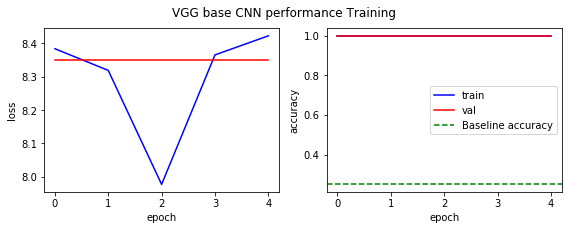

In [27]:
plot_history(history4, 'VGG base CNN performance')

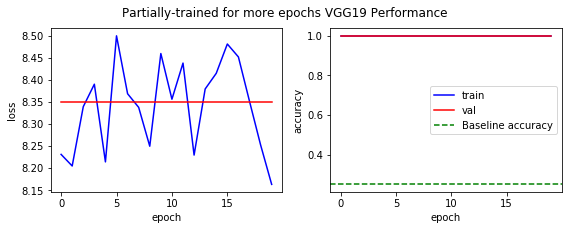

In [201]:
plot_history(history4, 'Partially-trained for more epochs VGG19')

In [118]:
vgg.save_weights("vgg.h5")
print("Saved weights")
vgg.load_weights("vgg.h5")
print("Load weights")

Saved weights
Load weights


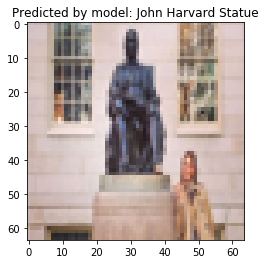

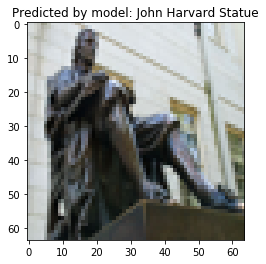

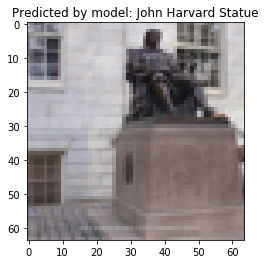

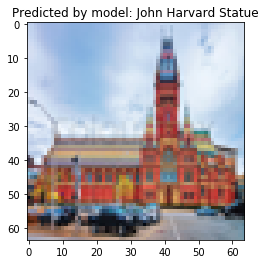

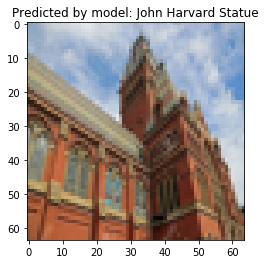

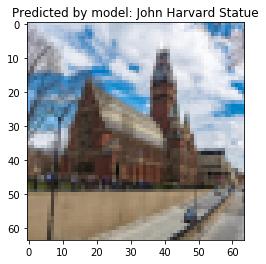

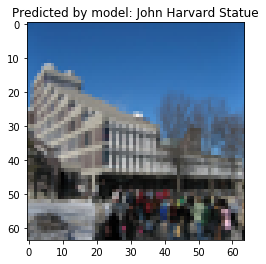

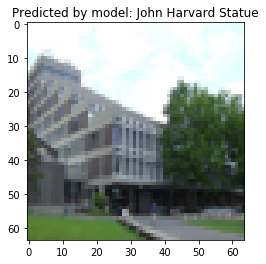

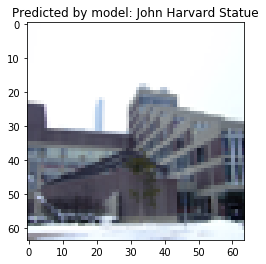

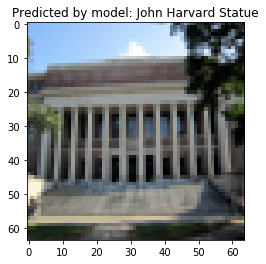

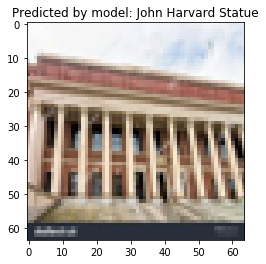

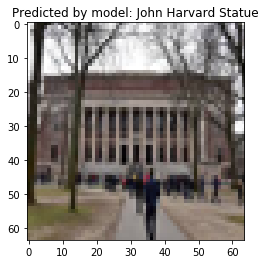

In [119]:
test_model(vgg)

In [164]:
from tensorflow.keras.applications import resnet50
resnet_base = resnet50.ResNet50(weights= 'imagenet', include_top=False, pooling='max', input_shape = (64,64, 3))
resnet_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_16[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [49]:
for layer in resnet_base.layers[:-5]:
    layer.trainable = False

for layer in resnet_base.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000016CB5AAE948> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000016CB5AAE6C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016CB5AAEE88> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x0000016CB5AA23C8> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000016CB18E4508> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000016CB18DDCC8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000016CB56A3AC8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016CB56B0048> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x0000016CB570C348> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000016CB5706F88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016CB571194

In [85]:
resnet = models.Sequential()
resnet.add(resnet_base)
resnet.add(layers.Dense(total_classes, activation='softmax'))
resnet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


In [51]:
resnet.compile(loss="sparse_categorical_crossentropy", optimizer=adam,
              metrics = ['accuracy'])

checkpoint = ModelCheckpoint("resnet_classifier.h5", monitor = 'val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

history5 = resnet.fit_generator(train_generator,
                             steps_per_epoch= STEP_SIZE_TRAIN/8,
                             epochs=epochs,  
                             shuffle=True,
                             validation_data=validation_generator,
                             callbacks=[checkpoint],
                             validation_steps= STEP_SIZE_VALID/8)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 111.125 steps, validate for 27.75 steps
Epoch 1/20
112/111 [==============================] - 74s 664ms/step - loss: 26.0588 - accuracy: 0.2938 - val_loss: 39.3896 - val_accuracy: 0.3036
Epoch 2/20
112/111 [==============================] - 69s 620ms/step - loss: 27.6401 - accuracy: 0.2955 - val_loss: 37.1391 - val_accuracy: 0.2679
Epoch 3/20
112/111 [==============================] - 70s 627ms/step - loss: 26.5661 - accuracy: 0.2843 - val_loss: 38.4403 - val_accuracy: 0.4096
Epoch 4/20
112/111 [==============================] - 67s 603ms/step - loss: 26.7590 - accuracy: 0.2905 - val_loss: 33.7954 - val_accuracy: 0.3906
Epoch 5/20
112/111 [==============================] - 62s 552ms/step - loss: 27.9459 - accuracy: 0.2899 - val_loss: 36.4420 - val_accuracy: 0.3962
Epoch 6/20
112/111 [==============================] - 76s 680ms/step - loss: 26.6583 - accuracy: 0.2868 - val_loss: 38.8842 - val_accuracy: 0.3136
Epoch 7/20
112/111

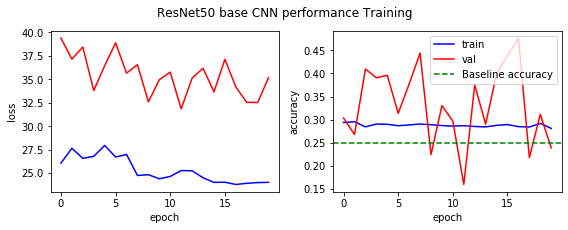

In [52]:
plot_history(history5, 'Partially-trained ResNet50')

In [69]:
# let's try building a resnet from scratch

#Based on this: https://cv-tricks.com/keras/understand-implement-resnets/

#ax: defines the axis which will perform batch normalization
#reduce: whether to reduce spatial dimensions 
#reg: regularization all CONV layers in the residual block
#bnE: Epsilon for avoiding “division by zero” errors when normalizing inputs
#bnM: momentum for the moving average

# setting up network architecture variables
inputShape = (64,64,3)
filters= (64, 128, 256, 512)
stages=(3, 4, 6) 
reg=0.0001

# batch normalization momentum and epsilon
bnE=2e-5
bnM=0.9
ax = -1

# creating the residual blocks thaare being appiled over and over again
def residual_block(inputs, K, stride, ax, reduce=False, 
        reg=0.0001, bnE=2e-5, bnM=0.9):
    
    # the shortcut branch of the ResNet module should be
    # initialize as the input (identity) data
    shortcut = inputs
    # the first block of the ResNet module are the 1x1 CONVs
    bn1 = BatchNormalization(axis=ax, epsilon=bnE, momentum=bnM)(inputs)
    act1 = Activation("relu")(bn1)
    conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False, kernel_regularizer=l2(reg))(act1)
    # the second block of the ResNet module are the 3x3 CONVs
    bn2 = BatchNormalization(axis=ax, epsilon=bnE, momentum=bnM)(conv1)
    act2 = Activation("relu")(bn2)
    conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride, padding="same", use_bias=False, kernel_regularizer=l2(reg))(act2)
    bn3 = BatchNormalization(axis=ax, epsilon=bnE,momentum=bnM)(conv2)
    act3 = Activation("relu")(bn3)
    conv3 = Conv2D(K, (1, 1), use_bias=False, kernel_regularizer=l2(reg))(act3)
    if reduce:
        shortcut = Conv2D(K, (1, 1), strides=stride, use_bias=False, kernel_regularizer=l2(reg))(act1)            
    #add together the shortcut and the final CONV
    x = add([conv3, shortcut])

    # return the addition as the output of the ResNet module
    return x

In [123]:
# Time to build the model

# set the input and apply BN
inputs = Input(shape=inputShape)
x = BatchNormalization(epsilon=bnE, momentum=bnM)(inputs)

# apply Conv, BN, Activation, and finally pooling to reduce spatial size
x = Conv2D(filters[0], (5, 5), use_bias=False, padding="same", kernel_regularizer=l2(reg))(x)
x = BatchNormalization(epsilon=bnE, momentum=bnM)(x)
x = Activation("relu")(x)
x = ZeroPadding2D((1, 1))(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

# loop over the number of stages
for i in range(0, len(stages)):
# initialize the stride, then apply residual blocks \
    stride = (1, 1) if i == 0 else (2, 2)
    x = residual_block(x, filters[i + 1], stride, ax, reduce=True)

    # loop over the number of layers in the stage
    for j in range(0, stages[i] - 1):
    # apply a residual block
        x = residual_block(x, filters[i + 1], (1, 1), ax)
    
# apply BN, Activation, and finally pooling to reduce spatial size
x = BatchNormalization(axis=ax, epsilon=bnE, momentum=bnM)(x)
x = Activation("relu")(x)
x = AveragePooling2D((8, 8))(x)

# final classifier
x = Flatten()(x)
x = Dense(total_classes, kernel_regularizer=l2(reg), activation = 'softmax')(x)

# create the model
my_resnet = Model(inputs, x, name="my_resnet")

In [76]:
my_resnet.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics = ['accuracy'])
my_resnet.summary()

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 64, 64, 3)    12          input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 64, 64, 64)   4800        batch_normalization_50[0][0]     
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 64, 64, 64)   256         conv2d_49[0][0]                  
_____________________________________________________________________________________________

In [78]:
checkpoint = ModelCheckpoint("my_resnet_classifier.h5", monitor = 'val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

history6 = my_resnet.fit_generator(train_generator,
                             steps_per_epoch= STEP_SIZE_TRAIN/8,
                             epochs=20,  
                             shuffle=True,
                             validation_data=validation_generator,
                             callbacks=[checkpoint],
                             validation_steps= STEP_SIZE_VALID/8)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 111.125 steps, validate for 27.75 steps
Epoch 1/20
112/111 [==============================] - 323s 3s/step - loss: 23.9431 - accuracy: 0.7377 - val_loss: 20.8717 - val_accuracy: 0.7388
Epoch 2/20
112/111 [==============================] - 323s 3s/step - loss: 17.9240 - accuracy: 0.7815 - val_loss: 15.8560 - val_accuracy: 0.7946
Epoch 3/20
112/111 [==============================] - 323s 3s/step - loss: 13.7269 - accuracy: 0.8047 - val_loss: 12.3187 - val_accuracy: 0.7969
Epoch 4/20
112/111 [==============================] - 319s 3s/step - loss: 10.7497 - accuracy: 0.8136 - val_loss: 9.7655 - val_accuracy: 0.7757
Epoch 5/20
112/111 [==============================] - 324s 3s/step - loss: 8.5077 - accuracy: 0.8722 - val_loss: 8.1643 - val_accuracy: 0.7411
Epoch 6/20
112/111 [==============================] - 393s 4s/step - loss: 6.8535 - accuracy: 0.9185 - val_loss: 6.6793 - val_accuracy: 0.7779
Epoch 7/20
112/111 [===============

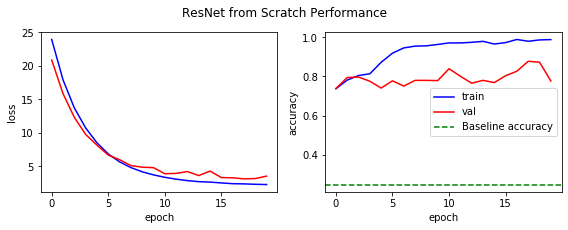

In [199]:
plot_history(history6, 'ResNet from Scratch')

In [135]:
my_resnet.save_weights("my_resnet.h5")
print("Saved weights")
my_resnet.load_weights("my_resnet.h5")
print("Load weights")

Saved weights
Load weights


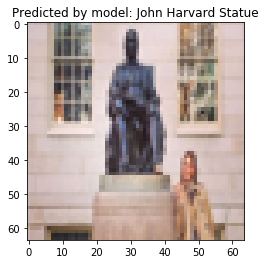

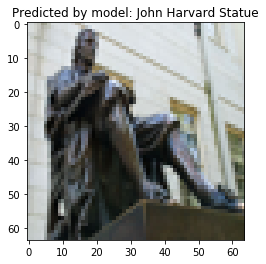

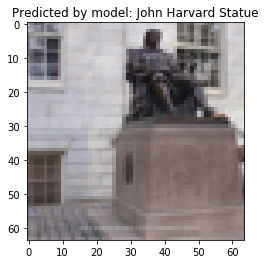

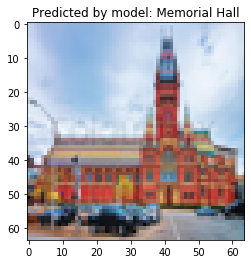

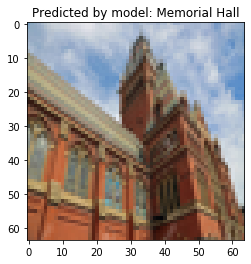

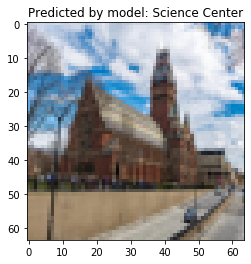

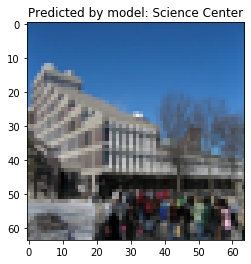

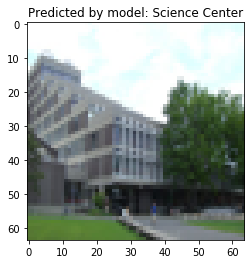

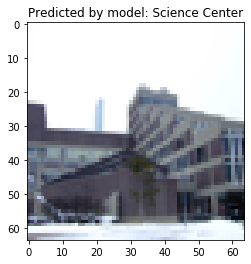

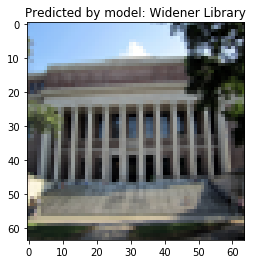

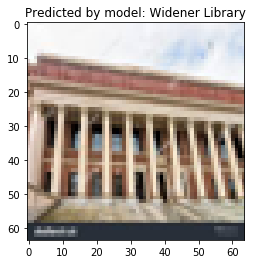

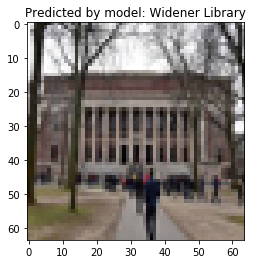

In [120]:
test_model(my_resnet)

In [84]:
# time to train the pre-trained resnet by setting all layers to trainable 
for layer in resnet_base.layers[:]:
    layer.trainable = True

for layer in resnet_base.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000016CFDB3E2C8> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000016CFDB3EE48> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016CFDB3E648> True
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x0000016CFDB38748> True
<tensorflow.python.keras.layers.core.Activation object at 0x0000016CFDB32588> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000016CFDB5A6C8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000016CFDBA1308> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016CFDBABBC8> True
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x0000016CFDC5BE08> True
<tensorflow.python.keras.layers.core.Activation object at 0x0000016CFDC658C8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016CFDC70108> True
<t

In [125]:
resnet = models.Sequential()
resnet.add(resnet_base)
resnet.add(layers.Dense(total_classes, activation='softmax'))
resnet.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


In [86]:
resnet.compile(loss="sparse_categorical_crossentropy", optimizer='adam',
              metrics = ['accuracy'])

checkpoint = ModelCheckpoint("resnet_classifier.h5", monitor = 'val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

history7 = resnet.fit_generator(train_generator,
                             steps_per_epoch= STEP_SIZE_TRAIN/8,
                             epochs=epochs,  
                             shuffle=True,
                             validation_data=validation_generator,
                             callbacks=[checkpoint],
                             validation_steps= STEP_SIZE_VALID/8)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 111.125 steps, validate for 27.75 steps
Epoch 1/20
112/111 [==============================] - 365s 3s/step - loss: 0.5336 - accuracy: 0.9007 - val_loss: 3520195.5586 - val_accuracy: 0.2467
Epoch 2/20
112/111 [==============================] - 348s 3s/step - loss: 0.2430 - accuracy: 0.9361 - val_loss: 1.5688 - val_accuracy: 0.7444
Epoch 3/20
112/111 [==============================] - 350s 3s/step - loss: 0.0604 - accuracy: 0.9835 - val_loss: 0.6553 - val_accuracy: 0.8650
Epoch 4/20
112/111 [==============================] - 349s 3s/step - loss: 0.0978 - accuracy: 0.9900 - val_loss: 0.2883 - val_accuracy: 0.9230
Epoch 5/20
112/111 [==============================] - 348s 3s/step - loss: 0.0128 - accuracy: 0.9955 - val_loss: 0.3417 - val_accuracy: 0.9118
Epoch 6/20
112/111 [==============================] - 350s 3s/step - loss: 0.0230 - accuracy: 0.9933 - val_loss: 0.3011 - val_accuracy: 0.9096
Epoch 7/20
112/111 [================

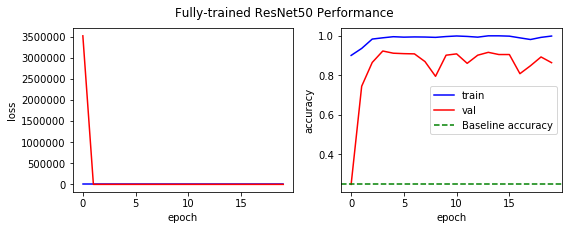

In [198]:
plot_history(history7, 'Fully-trained ResNet50')

In [126]:
resnet.save_weights("resnet.h5")
print("Saved weights")
resnet.load_weights("resnet.h5")
print("Load weights")

Saved weights
Load weights


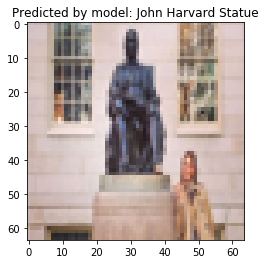

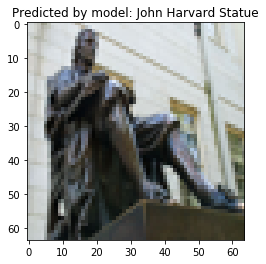

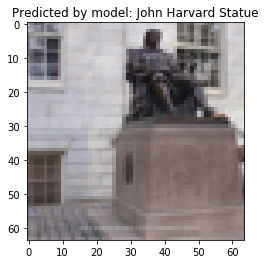

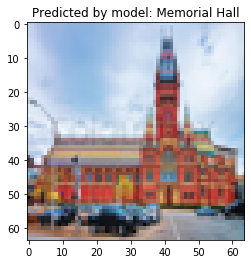

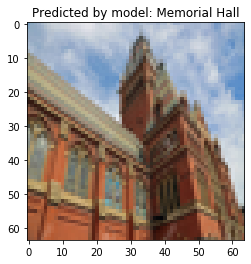

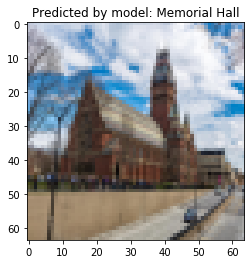

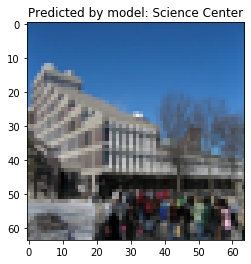

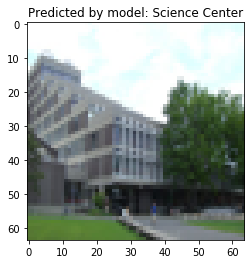

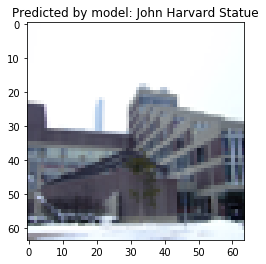

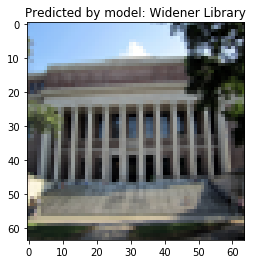

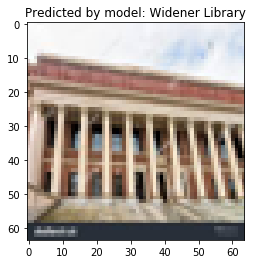

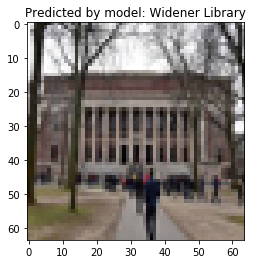

In [112]:
test_model(resnet)

In [124]:
# time to train the pre-trained vgg by setting all layers to trainable 
for layer in vgg_base.layers[:]:
    layer.trainable = True

for layer in vgg_base.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000016C833FFC88> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016C80FBEF88> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016C800205C8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000016C81737108> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016C84B49808> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016C82985DC8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000016C82987908> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016C80F741C8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016C80F7FBC8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016C80F80888> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000016C80F8B0C8> True
<tensorflow.python.keras.layer

In [128]:
vgg = models.Sequential()
vgg.add(vgg_base)
vgg.add(layers.Dense(total_classes, activation='softmax'))
vgg.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 2052      
Total params: 14,716,740
Trainable params: 14,716,740
Non-trainable params: 0
_________________________________________________________________


In [138]:
vgg.compile(loss="sparse_categorical_crossentropy", optimizer='adam',
              metrics = ['accuracy'])

checkpoint = ModelCheckpoint("vgg_classifier.h5", monitor = 'val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

history8 = vgg.fit_generator(train_generator,
                             steps_per_epoch= STEP_SIZE_TRAIN/8,
                             epochs=epochs,  
                             shuffle=True,
                             validation_data=validation_generator,
                             callbacks=[checkpoint],
                             validation_steps= STEP_SIZE_VALID/8)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 111.125 steps, validate for 27.75 steps
Epoch 1/20
112/111 [==============================] - 279s 2s/step - loss: 1.3863 - accuracy: 0.2414 - val_loss: 1.3990 - val_accuracy: 0.2467
Epoch 2/20
112/111 [==============================] - 283s 3s/step - loss: 1.3865 - accuracy: 0.2400 - val_loss: 1.3990 - val_accuracy: 0.2467
Epoch 3/20
112/111 [==============================] - 294s 3s/step - loss: 1.3862 - accuracy: 0.2609 - val_loss: 1.3993 - val_accuracy: 0.2366
Epoch 4/20
112/111 [==============================] - 282s 3s/step - loss: 1.3864 - accuracy: 0.2472 - val_loss: 1.3992 - val_accuracy: 0.2366
Epoch 5/20
112/111 [==============================] - 285s 3s/step - loss: 1.3865 - accuracy: 0.2405 - val_loss: 1.3988 - val_accuracy: 0.2589
Epoch 6/20
112/111 [==============================] - 276s 2s/step - loss: 1.3863 - accuracy: 0.2433 - val_loss: 1.3989 - val_accuracy: 0.2589
Epoch 7/20
112/111 [======================

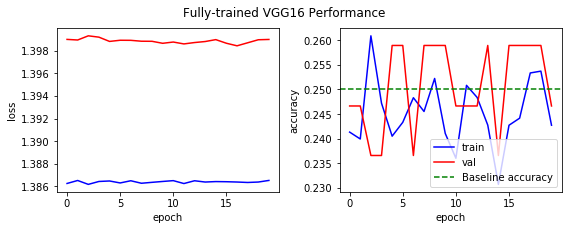

In [197]:
plot_history(history8, 'Fully-trained VGG16')

In [140]:
vgg.save_weights("vgg.h5")
print("Saved weights")
vgg.load_weights("vgg.h5")
print("Load weights")

Saved weights
Load weights


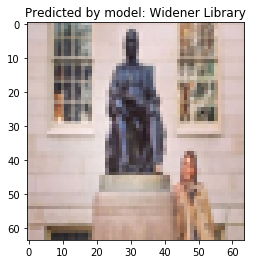

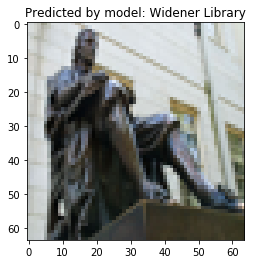

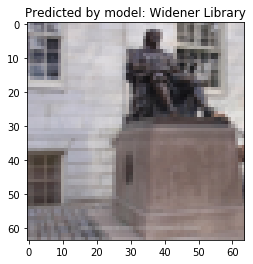

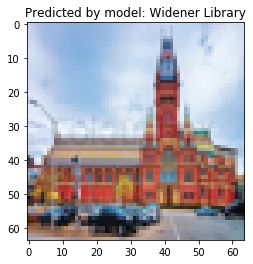

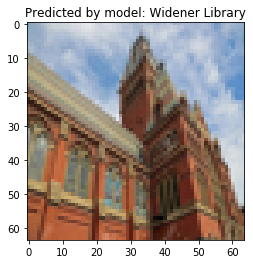

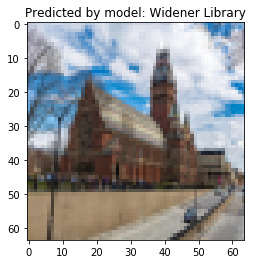

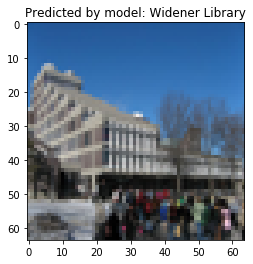

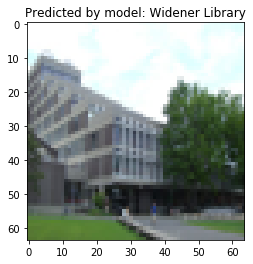

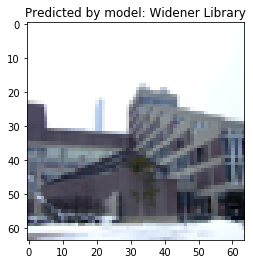

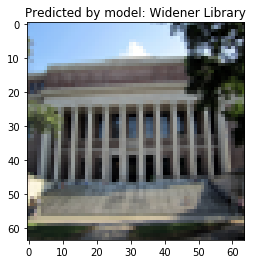

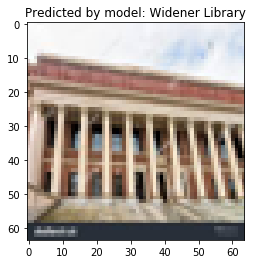

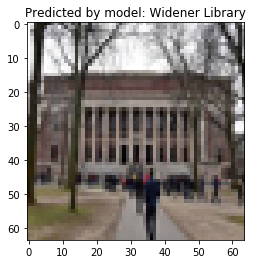

In [141]:
test_model(vgg)

In [151]:
resnet_fc = models.Sequential()
resnet_fc.add(resnet_base)
resnet_fc.add(layers.Dense(1024, activation='relu'))
resnet_fc.add(layers.Dense(total_classes, activation='softmax'))
resnet_fc.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 4100      
Total params: 25,689,988
Trainable params: 25,636,868
Non-trainable params: 53,120
_________________________________________________________________


In [143]:
resnet_fc.compile(loss="sparse_categorical_crossentropy", optimizer='adam',
              metrics = ['accuracy'])

checkpoint = ModelCheckpoint("resnet_fc_classifier.h5", monitor = 'val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

history9 = resnet_fc.fit_generator(train_generator,
                             steps_per_epoch= STEP_SIZE_TRAIN/8,
                             epochs=epochs,  
                             shuffle=True,
                             validation_data=validation_generator,
                             callbacks=[checkpoint],
                             validation_steps= STEP_SIZE_VALID/8)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 111.125 steps, validate for 27.75 steps
Epoch 1/20
112/111 [==============================] - 266s 2s/step - loss: 0.1622 - accuracy: 0.9688 - val_loss: 1.8457 - val_accuracy: 0.8482
Epoch 2/20
112/111 [==============================] - 258s 2s/step - loss: 0.0374 - accuracy: 0.9891 - val_loss: 0.3504 - val_accuracy: 0.9208
Epoch 3/20
112/111 [==============================] - 258s 2s/step - loss: 0.1005 - accuracy: 0.9777 - val_loss: 3.3162 - val_accuracy: 0.5301
Epoch 4/20
112/111 [==============================] - 257s 2s/step - loss: 0.1092 - accuracy: 0.9741 - val_loss: 66.9044 - val_accuracy: 0.5335
Epoch 5/20
112/111 [==============================] - 258s 2s/step - loss: 0.9191 - accuracy: 0.8853 - val_loss: 481.0874 - val_accuracy: 0.4174
Epoch 6/20
112/111 [==============================] - 257s 2s/step - loss: 0.0934 - accuracy: 0.9735 - val_loss: 0.6355 - val_accuracy: 0.8415
Epoch 7/20
112/111 [===================

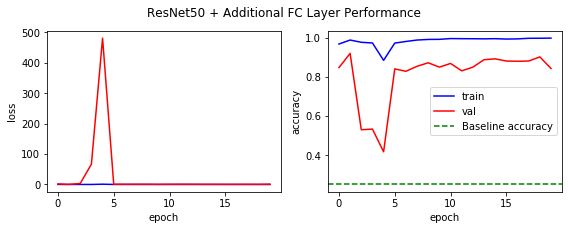

In [196]:
plot_history(history9, 'ResNet50 + Additional FC Layer')

In [145]:
resnet_fc.save_weights("resnet_fc.h5")
print("Saved weights")
resnet_fc.load_weights("resnet_fc.h5")
print("Load weights")

Saved weights
Load weights


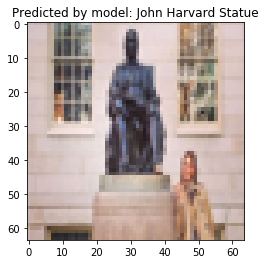

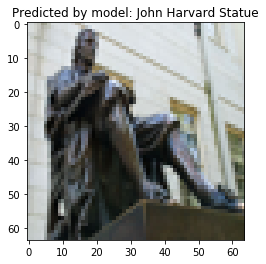

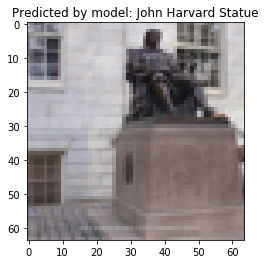

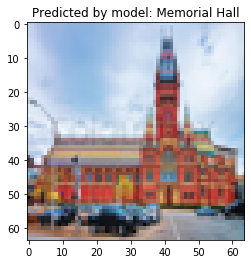

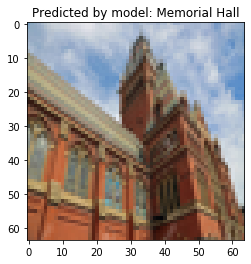

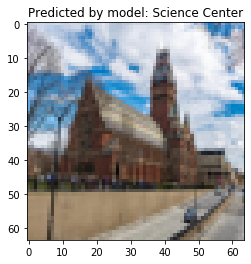

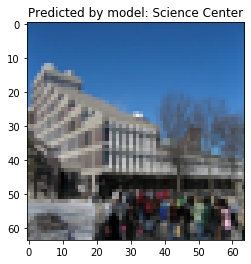

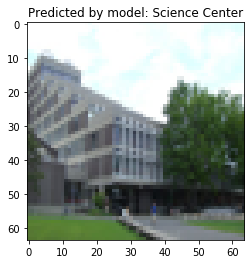

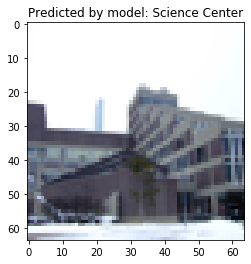

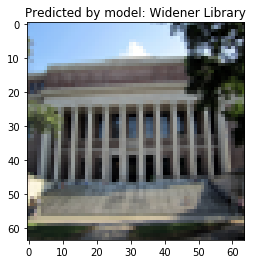

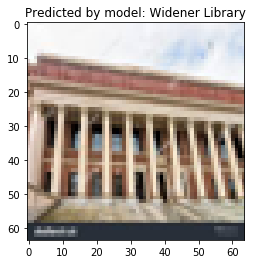

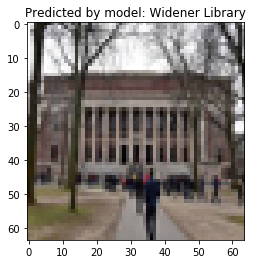

In [146]:
test_model(resnet_fc)

In [188]:
base_output = resnet_base.layers[174].output
new_output = AveragePooling2D((2, 2))(base_output)
new_output = Flatten()(new_output)
new_output = Dense(total_classes, activation='softmax')(new_output)
resnet_ga = Model(inputs=resnet_base.inputs, outputs=new_output)
resnet_ga.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_16[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [189]:
resnet_ga.compile(loss="sparse_categorical_crossentropy", optimizer='adam',
              metrics = ['accuracy'])

checkpoint = ModelCheckpoint("resnet_ga_classifier.h5", monitor = 'val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

history10 = resnet_ga.fit_generator(train_generator,
                             steps_per_epoch= STEP_SIZE_TRAIN/8,
                             epochs=epochs,  
                             shuffle=True,
                             validation_data=validation_generator,
                             callbacks=[checkpoint],
                             validation_steps= STEP_SIZE_VALID/8)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 111.125 steps, validate for 27.75 steps
Epoch 1/20
112/111 [==============================] - 268s 2s/step - loss: 0.2428 - accuracy: 0.9216 - val_loss: 20.2321 - val_accuracy: 0.7221
Epoch 2/20
112/111 [==============================] - 259s 2s/step - loss: 0.1066 - accuracy: 0.9796 - val_loss: 157.9674 - val_accuracy: 0.4542
Epoch 3/20
112/111 [==============================] - 279s 2s/step - loss: 0.1239 - accuracy: 0.9701 - val_loss: 54.9398 - val_accuracy: 0.4632
Epoch 4/20
112/111 [==============================] - 280s 2s/step - loss: 0.0463 - accuracy: 0.9860 - val_loss: 1.4410 - val_accuracy: 0.7355
Epoch 5/20
112/111 [==============================] - 282s 3s/step - loss: 0.1895 - accuracy: 0.9646 - val_loss: 130313.3637 - val_accuracy: 0.2723
Epoch 6/20
112/111 [==============================] - 269s 2s/step - loss: 0.0775 - accuracy: 0.9785 - val_loss: 1.4478 - val_accuracy: 0.6908
Epoch 7/20
112/111 [=============

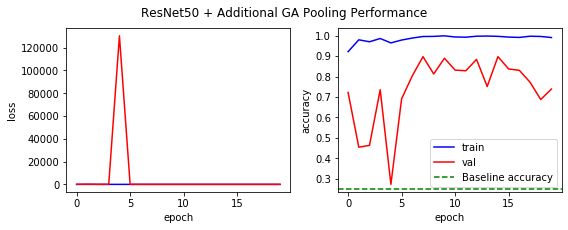

In [195]:
plot_history(history10, 'ResNet50 + Additional GA Pooling')

In [191]:
resnet_ga.save_weights("resnet_ga.h5")
print("Saved weights")
resnet_ga.load_weights("resnet_ga.h5")
print("Load weights")

Saved weights
Load weights


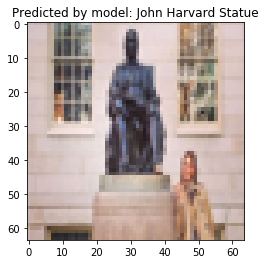

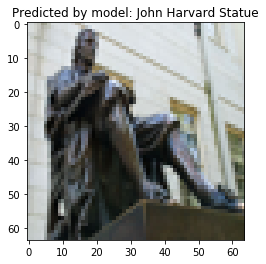

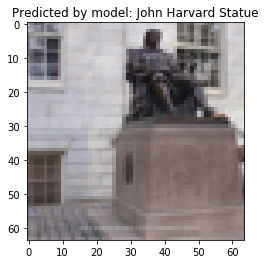

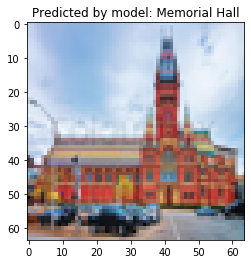

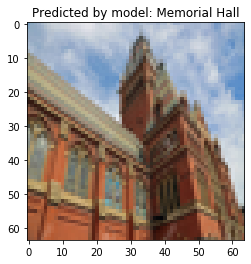

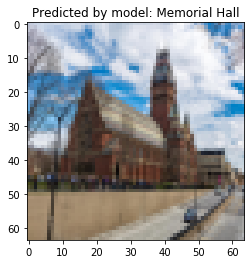

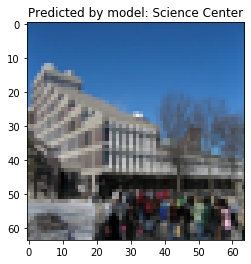

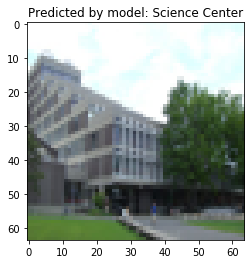

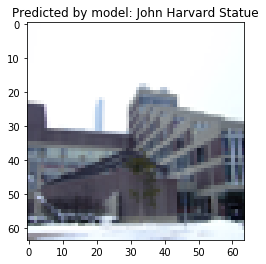

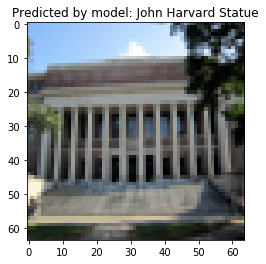

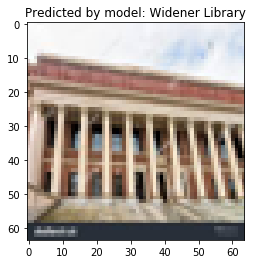

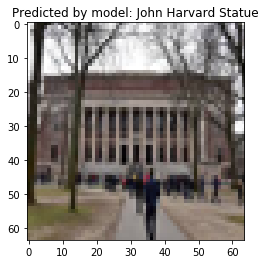

In [192]:
test_model(resnet_ga)